YDELSESTYPE
 id = TOT, text = Gross unemployment
 id = LDP, text = Net unemployed recipients of unemployment benefits
 id = LKT, text = Net unemployed recipients of social assistance
 id = ADP, text = Activation of persons on unemployment benefits
 id = AKT, text = Activation of persons on social assistance (prepared for employment)
ALDER
 id = TOT, text = Age, total
 id = 16-24, text = 16-24 years
 id = 25-29, text = 25-29 years
 id = 30-39, text = 30-39 years
 id = 40-49, text = 40-49 years
 id = 50-59, text = 50-59 years
 id = 6099, text = 60 year and over
KØN
 id = TOT, text = Total
 id = M, text = Men
 id = K, text = Women


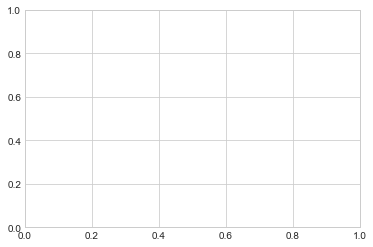

In [1]:
import numpy as np
import pandas as pd
import datetime

import pandas_datareader 
import pydst 
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')


#Begin to download data using pydst: Danish Statistical Banks Python integration
Dst = pydst.Dst(lang='en')
Dst.get_subjects()
tables = Dst.get_tables(subjects=['04'])
tables[tables.id == 'AUF01']
unempl_pers = Dst.get_variables(table_id='AUF01')

#We find the possible IDs for the chosen variables within the table and prints them with
#their associated text to describe the IDs
for id in ['YDELSESTYPE','ALDER','KØN']:
    
    print(id)
    values = unempl_pers.loc[unempl_pers.id == id,['values']].values[0,0]
    for value in values:      
        print(f' id = {value["id"]}, text = {value["text"]}')

#We now use the IDs found to write, which variables we want to include for each column.
variables = {'OMRÅDE':['*'],'YDELSESTYPE':['TOT'],'ALDER':['TOT'],'KØN':['*'],'TID':['*']}
#We now import data from the table_id with the variables we want
unempl_AUF1 = Dst.get_data(table_id= 'AUF01', variables=variables)
unempl_AUF2 = Dst.get_data(table_id= 'AUF02', variables=variables)

#Rewrite the TID parameter to be in datetime (We go from ex. 2020M01 to 2020-01-01)
unempl_AUF1.loc[:,'TID']= pd.to_datetime(unempl_AUF1.loc[:,'TID'].str.replace('M',''),format='%Y%m')
unempl_AUF2.loc[:,'TID']= pd.to_datetime(unempl_AUF2.loc[:,'TID'].str.replace('M',''),format='%Y%m')

#Since AUF2 has the actual unemployment numbers, but AUF1 have more recent data, we choose to merge these.
I = (unempl_AUF1["TID"] > "2020-08-01") #Choose to stack only rows in AUF1, where there are newer data than in AUF2
unempl_AUF1 = unempl_AUF1.loc[I == True] #Overwrite the variable, where I is true.
outer = pd.merge(unempl_AUF1, unempl_AUF2, how='outer') #merge the two data sets

#Beginning of data cleaning
unempl = outer.copy()
unempl.rename(columns = {"OMRÅDE": "municipality", "ALDER":"age", "KØN":"gender","TID":"time","INDHOLD":"unemployed"}, inplace=True) #Renames the columns from Danish to English
drop_columns = ["YDELSESTYPE", "AKASSE"] #Drops the data from YDELSESTYPE and AKASSE as they are unimportant for this assignment
unempl.drop(drop_columns, axis=1, inplace=True)
unempl = unempl.sort_values(['municipality', 'time']) #Sorts the dataset by municipality then time

#Deletes any row, where it isn't a municipality
I = unempl.municipality.str.contains('Region')
I |= unempl.municipality.str.contains('Province')
I |= unempl.municipality.str.contains('All Denmark')
unempl = unempl.loc[I == False] #Keep everything that isn't "I"

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

In [2]:
#Widget for unemployed sortable by municipality and gender
import ipywidgets as widgets
def plot_interact(df, municipality, gender):
    I = df['municipality'] == municipality
    I &= df['gender'] == gender
    df.loc[I,:].plot(x='time', y = 'unemployed', style='-o', legend=False)
widgets.interact(plot_interact, 
    df = widgets.fixed(unempl),
    municipality = widgets.Dropdown(description='Municipality', 
    options=unempl.municipality.unique(), 
    value='Roskilde'),
    gender = widgets.Dropdown(description='Gender',
    options=unempl.gender.unique(),
    value='Men')
)

interactive(children=(Dropdown(description='Municipality', index=73, options=('Aabenraa', 'Aalborg', 'Aarhus',…

<function __main__.plot_interact(df, municipality, gender)>

In [3]:
#Procent change on total for men and women 
unique_areas = unempl['municipality'].unique() #Creates an array of each unique municipality name

for area in unique_areas: #Takes each individual area with the restriction that gender = Total. Then it loops over each area and creates the pct change
    I = (unempl['municipality']==area) & (unempl['gender'] == 'Total')
    unempl.loc[I, 'pct change'] = unempl.loc[I,'unemployed'].pct_change(fill_method='ffill')

In [4]:
unempl_pct = unempl[unempl['gender'] == 'Total']
unempl_pct

,municipality,age,gender,time,unemployed,pct change
6889,Aabenraa,"Age, total",Total,2007-01-01,1500,NaN
2369,Aabenraa,"Age, total",Total,2007-02-01,1443,-0.038000
6960,Aabenraa,"Age, total",Total,2007-03-01,1325,-0.081774
3195,Aabenraa,"Age, total",Total,2007-04-01,1306,-0.014340
3294,Aabenraa,"Age, total",Total,2007-05-01,1191,-0.088055
...,...,...,...,...,...,...
563,Ærø,"Age, total",Total,2020-10-01,69,-0.028169
845,Ærø,"Age, total",Total,2020-11-01,86,0.246377
1169,Ærø,"Age, total",Total,2020-12-01,94,0.093023
1259,Ærø,"Age, total",Total,2021-01-01,107,0.138298


In [5]:
def plot_interact(df, municipality):
    I = df['municipality'] == municipality
    df.loc[I,:].plot.bar(x='time', y = 'pct change', style='-o', legend=False)
    plt.locator_params(axis='x', nbins=15)
widgets.interact(plot_interact, 
    df = widgets.fixed(unempl_pct),
    municipality = widgets.Dropdown(description='Municipality', 
    options=unempl.municipality.unique(), 
    value='Roskilde')
)

interactive(children=(Dropdown(description='Municipality', index=73, options=('Aabenraa', 'Aalborg', 'Aarhus',…

<function __main__.plot_interact(df, municipality)>